# Pybamm - C-Rate Experiment - Testnotebook
In diesem Notebook soll eine Simulation einer NMC811 Zelle mit Daten aus der Literatur basierend mit einem Laborzellenaufbau mit einem NMC811/Graphit PAT-Zellaufbau in 3-Elektrodenanordnung verglichen werden. Die Literaturdaten basieren auf einem Paper von Chen et al. aus dem Jahr 2020<sup>1</sup>. Für eine genaue Simulation werden charakterische Unterschiede zwischen den experimentellen und Literaturdaten bestimmt und, aufgrund der erkannten Unterschiede, die entsprechenden Parameter angepasst.

Dies sind zum geometrische, elektrische und thermodynamische Eigenschaften. Auf diese wird an entsprechender Stelle im Verlauf des Notebooks mit Hinweis auf PyBaMMs zugrundliegende Struktur hingewiesen. 

Vor Beginn der Simulation müssen alle notwendigen Pakete geladen werden. Dabei ist allen voran das Modelltoolbox "PyBaMM" zu nennen.

<sup>1</sup>: Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050 

In [1]:
# pip install pybamm

In [2]:
# %reload_ext autoreload
# %autoreload 2

# %pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
from datetime import datetime

# os.chdir(pybamm.__path__[0]+'/..')
# print(os.getcwd())
pybamm.PARAMETER_PATH
# print(__file__)
# print(os.path.dirname(__file__))

['c:\\users\\ahe16\\documents\\github\\pybamm_fork',
 'c:\\Users\\ahe16\\Documents\\GitHub\\PyBaMM_Fork\\scripts\\testing\\Laborzelle\\C_rate_experiment',
 'c:\\users\\ahe16\\documents\\github\\pybamm_fork\\pybamm\\input\\parameters']

#### Determine your path!
Bitte hier einmal deinen lokalen Pfand zu dem Verzeichnis wo das Skript lieght hinlegen. Ich habe es bei mir bisher leider nicht geschafft den Ablageort des Skripts direkt über Python zu bestimmten

In [3]:
# pathlib.Path("")
# pathlib.Path.cwd()
print(os.path.abspath(""))

c:\Users\ahe16\Documents\GitHub\PyBaMM_Fork\scripts\testing\Laborzelle\C_rate_experiment


## 1 Modellwahl
In der Arbeitsabfolge muss nächst anhand der Anforderungen an die zu gewinnen Modelllöung ein geeigneter Lithium Ionen Modellansatz gewählt werden. Bei Beachtung der Fragestellungen im Graduiertenkolleg wird ein elektrochemisches und physikalisches Modell gewählt, was eine gute Dokumentation und Genauigkeit aufweist. Das ist das *Doyle-Fuller-Newman* Modell. Dieses wird entsprechend auch für dieses C-Raten Beispiel gewählt, um möglichst sinnvolle Erfahrungen für die spätere Anwendung zu sammeln.

Das in **PyBaMM** gewählte Modell legt fest welche Parameter für die Simulation benötigt werden. Die gesamte Liste kann über den Befehl `model.print_parameter_info` eingesehen werden. Die Parameter unterscheiden sich dabei in zwei Kategorien. Es gibt *Parameter*, die als Konstanten definiert werden, und es gibt *FunctionParameter*, die durch eine Funktion in Abhängigkeit von den gegebenen Inputgrößen berechnet werden.

Mit den Parametern werden für das gewählte Modell eine Vielzahl von Variablen örtlich und/oder zeitlich berechnet. Diese können analog zu den Parametern durch den Befehl `model.variable_names` auch in Gänze ausgegeben werden. Zur Suche nach einzelnen Variablen in der "dict" Struktur kann außerdem der Befehl `model.variables.search("*suchbegriff*")` genutzt werden.

#### to do
- Annahmen für das DFN Modell auflisten
- Erweitert sich die Liste automatisch wenn man einzelne Untermodelle austauscht oder verändert?
- Möglichkeit zur Nutzung mehrerer Modell für den direkten Vergleich mit aufnehmen

In [4]:
dfn = pybamm.lithium_ion.DFN() # "name" beschreibt welchen Namen das Modell in der Lösung hat
dfnD= pybamm.lithium_ion.DFN(options={"particle": "quartic profile"},name="dfnD")
### Auflistung aller im Modell berücksichtigten Untermodelle #dict
dfn.submodels["positive primary particle"]



### 1.1 Untermodellwahl
Jedes in **1** gewählte Lihtium-Ionen Batteriemodell ist modular aus mehreren Untermodellen aufgebaut, die zum Teil Parameter unabhängig von anderen Modellen einführen `fundamental variables` und andere Variablen `coupled variables`, die sich mit anderen Modellen geteilt werden. 

Die Wahl der tatsächlich zu simulierenden Modelle kann derzeit am einfachsten durch die Veränderung der `models` Liste durchgeführt werden.

#### to-do


In [5]:
submodels={"particle mechanics":"swelling only"} # "thermal" : "lumped"
tme_dfn = pybamm.lithium_ion.DFN(options=submodels,name="LumT-SwP-DFN")
dfn_thermal=dfn.submodels["thermal"]
dfn_nparticle=dfn.submodels["negative particle mechanics"]
tme_dfn_nparticle=tme_dfn.submodels["negative particle mechanics"]
tme_dfn_thermal=tme_dfn.submodels["thermal"]

models= [dfn] #, dfn
test=pybamm.particle_mechanics.SwellingOnly
pybamm.thermal.lumped.Lumped
# pybamm.dynamic_plot(sols, ["Terminal voltage [V]","Volume-averaged cell temperature [K]"])

pybamm.models.submodels.thermal.lumped.Lumped

In [6]:
print(dfn_nparticle)
print(tme_dfn_nparticle)
print(tme_dfn_thermal)
print(test)
# help(pybamm.lithium_ion.DFN)

<class 'pybamm.models.submodels.particle_mechanics.swelling_only.SwellingOnly'>


### 1.2 Festellen der Anforderungen der benötigten Parameter
Je nach Wahl der Untermodelle, müssen verschiedene Parameter und FunctionParameter bereitgestellt werden. Bei der Gestaltung des Modells wird vorausgesetzt welche Parameter und FunctionParameter gebraucht werden. Es ist dabei im Folgenden darauf zu achten, dass diese mit den Angaben des genutzten Parametersets übereinstimmen. Es gilt folgendes:
- FunctionParameter können mit Funktion oder Konstante definiert sein. Es ist zu beachten, dass der Input der FunctionParameter entsprechend der Vorgabe des Modells/Untermodells gewählt werden müssen.
- Parameter müssen mit einem Skalar definiert sein

Wie kann man bei den FunctionParametern erkennen welche Eingaben benötigt werden?

In [7]:
# Wo kann man aber den Rest ablesen? Wo kann ich mir die Gleichung ausgeben lassen?
# Am ehesten ist das über den Befehl latexify von dem Modell an sich möglich, um sich die Gleichungen ausgeben zu lassen. Die Temperaturabhängigkeiten sind allerdings nicht explizit aufgelistet. Dazu hilft dann ein Bilck in die Parameter des Modells
dfn_req_para=dfn.parameters
dfn_req_para # die Abhängigkeiten können hier abgelesen werden. 
# Der erste Eintrag in den Children beinhält die abhägngigen Größen. Im "Broadcast" darauf sind weitere Abhängigkeiten aufgelistet (meist, wenn nicht immer die Temperatur).

[FunctionParameter(0x111a54fd6fb31305, Negative electrode conductivity [S.m-1], children=['broadcast(broadcast(Ambient temperature [K]))'], domains={'primary': ['negative electrode'], 'secondary': ['current collector']}),
 FunctionParameter(0x3f5a1c267acbf211, Positive electrode OCP entropic change [V.K-1], children=['maximum(minimum(yz-average(x-average(r-average(Initial concentration in positive electrode [mol.m-3]))) / Maximum concentration in positive electrode [mol.m-3], 0.9999999999), 1e-10)', 'Maximum concentration in positive electrode [mol.m-3]'], domains={}),
 Parameter(-0x709ab677abd6d5e9, Ideal gas constant [J.K-1.mol-1], children=[], domains={}),
 Parameter(0x7cfe5a362fae2918, Upper voltage cut-off [V], children=[], domains={}),
 FunctionParameter(0x6f986a0ad4232120, Current function [A], children=['time'], domains={}),
 FunctionParameter(0x43933cb31d56c24, Negative electrode OCP entropic change [V.K-1], children=['maximum(minimum(x-average(Negative electrode active materi

# 2 Definition Parameterset
Die zur Beschreibung des Batteriesystems nötigen Gleichungen werden durch das Modell definiert.  Aus anfängliches Parameter Set wird, wie zuvor erwähnt, das Set von Chen et al. (2020) gewählt. Diese können für die einzelnen entweder Konstanten für *Parameter* oder Funktionen und Look Up tables (intern interpoliert) für *FunctionParameter* definiert sein. Das hier gewählte Parameter Set beschreibt ein kommerzielles NMC811/Graphite-SiO<sub>x</sub> Materialsystem in dem zyklindrischen 21700 Format (Produktname: LGM50). Das Set hier hat mehr Parameter, als das Modell benötigt. Zusätzliche Angaben werden nicht von dem gewählten Modell beachtet, außer es werden entsprechende Untermodell eingesetzt. Dadurch ergeben sich deutliche Unterschiede in der Geometrie und bei der negativen Elektrode im Vergleich zum zu vergleichenden Laborzellensystem.

Analog zu der Möglichkeit der Variablen Suche für das Modell können auf eine analoge Weise über `parameter_values.search("*Suchbegriff*")` die einzelnen Parameter gesucht werden.
Alle für das Modell benötigten Parameter müssen in dem Parameterset enthalten sein, da über die Programmieroberfläche ohne Weiteres keine weiteren Parameter in die PyBaMM Struktur aufgenommen werden können. Die Werte aller vorhandenen Parameter können aber angepasst werden.

So kann beispielsweise das Chen2020 Modell für kein "particle mechanic" Untermodell berechnet werden, da Parameter wie die partielle Volumenänderung der Elektrodenmaterialien abhängig vom Lithiierungsgrad nicht enthalten ist.

#### to do
- Mehr Parameter anpassen

In [8]:
parameter_values_comp = pybamm.ParameterValues("Chen2020") #'Chen2020_AH_VM_modified'

parameter_values_comp.search("positive") # Suche
print(dfn_req_para)

# parameter_values # Vollständige Parameterliste

Initial concentration in positive electrode [mol.m-3]	17038.0
Maximum concentration in positive electrode [mol.m-3]	63104.0
Positive current collector conductivity [S.m-1]	36914000.0
Positive current collector density [kg.m-3]	2700.0
Positive current collector specific heat capacity [J.kg-1.K-1]	897.0
Positive current collector thermal conductivity [W.m-1.K-1]	237.0
Positive current collector thickness [m]	1.6e-05
Positive electrode Bruggeman coefficient (electrode)	0
Positive electrode Bruggeman coefficient (electrolyte)	1.5
Positive electrode OCP [V]	<function nmc_LGM50_ocp_Chen2020 at 0x0000017CD144D1F0>
Positive electrode OCP entropic change [V.K-1]	0.0
Positive electrode active material volume fraction	0.665
Positive electrode charge transfer coefficient	0.5
Positive electrode conductivity [S.m-1]	0.18
Positive electrode density [kg.m-3]	3262.0
Positive electrode diffusivity [m2.s-1]	4e-15
Positive electrode double-layer capacity [F.m-2]	0.2
Positive electrode exchange-current den

## 2.1 Veränderung von FunctionParametern - Implementieren weiterer ParameterSets
Das Ändern von *FunctionParametern* kann im Gegensatz zu den Zahlenwerten der *Parameter* nicht einfach in einer Codezeile geändert werden. Dazu muss die hinterlegte Funktion verändert oder ersetzt werden. Dies kann mit geringem Risiko am besten durch das Verändern eines kopierten Parametersets erfüllt werden.
Im folgenden Beispiel wird das vorher geladene Parameterset "Chen2020" kopiert und die Definition der OCV Kurve der positiven Elektrode (NMC) verändert, die in diesem ParameterSet als *FunctionParameter* mit der Variablen der Stöchiometrie (sto) als Function hinterlegt ist. 

Das neue Parameterset "Chen2020_AH_VM_modified" wird in dem gleichen Ordner wie Chen2020 abgelegt. Allerdings werden die Parametersets mit der Innstallation des `PyBaMM` Packages vorher mithilfe von `entry points` definiert. Diese `entry points` sind unten in der "setup.py" Datei in der obesten Ebene der PyBaMM-Fork hinterlegt. Um das ParameterSet nun so zu hinterlegen, dass dieses wie die anderen gefunden werden kann, ohne durch eine Neuinstallation von `PyBaMM` sämtliche Änderungen am Quellcode wieder rückgängig zu machen, müssen folgende Schritte ausgeführt werden.

- Implementieren des modifizierten Parametersets analog zu den anderen Parametersets in "setup.py":  "Chen2020_AH_VM_modified = pybamm.input.parameters.lithium_ion.Chen2020_AH_VM_modified:get_parameter_values"
- Im CommandWindow (cmd.exe) als Admindestrator in das PyBaMM-Fork Verzeichnis gehen (Bsp.: cd C:/Users/ahe16/Documents/GitHub/PyBaMM_Fork) gehen
- Noch immer im cmd window "pip install -e ." ausführen. Daraufhin, wird PyBaMM neuinstalliert ohne, dass die setup.py Datei verändert wird.
    - Dadurch werden die DeveloperTools entwickelt, die eine Bearbeitung des Pakets an sich ermöglichen. Alternativ kann PyBaMM im cmd Fenster über "pip install pybamm -e C:/Users/ahe16/Documents/GitHub/PyBaMM_Fork" oder jedem anderen Ort installiert werden
        - In dem Fall sollten andere Pybamm distributionen bspw. in AppData entfernt werden
- Erneutes Ausführen des Skripts erlaubt das laden des modifizierten Parametersets und damit von anderen *FunctionParametern*

*zuletzt geändert am: 16.01.2023 AH*


In [9]:
parameter_values = pybamm.ParameterValues("Chen2020_AH_VM_modified") #Chen2020_AH_VM_modified

parameter_values.search("OCP")

Negative electrode OCP [V]	<function graphite_LGM50_ocp_Chen2020 at 0x0000017CAA272E50>
Negative electrode OCP entropic change [V.K-1]	0.0
Positive electrode OCP [V]	<function nmc_LGM50_ocp_Chen2020 at 0x0000017CD141BA60>
Positive electrode OCP entropic change [V.K-1]	0.0


### 2.1.1 Anpassung der positiven OCV Kurve
Die Stöchiometrie abhängigen OCV Kurven müssen für die positive und negative Elektrode festgelegt werden, da diese im Modell zur Berechnung der Spannung und Kinetik wichtig sind. Die positive Elektrode wird während der Entladung vollständig liithiert. Die negative Elektrode wird nicht vollständig lithiiert. Eine Lithium-Ionen Batterievollzelle ist in der Regel durch die theoretische Kapazität der der positiven Elektrode limitiert.

$$x = \frac{c_s}{c_s^{max}}$$

<span style="color:grey">Quelle: *Chen.2020*</span>.

x ist also dem Lithiierungsgrad der Elektrode gleich zu setzen. Für das Kathodenmaterial NMC811 bedeutet dies dann $Li_xNi_{0.8}Mn_{0.1}Co_{0.1}O_2$

Für eine Vollzelle können im 3-Elektrodensetup (FC) die Halbzellspannungen gegen Lithium über den Spannungsbereich der Vollzelle aufgenommen werden. Um den praktisch genutzten Ladezustand mit dem Lihtiierungsgrad der Elektroden in Zusammenhang zu bringen, sind außerdem GITT oder Pseudo-OCV Messungen an Li-Halbzellen (HC) notwenig, um über Lithiierungsbereich der Vollzelle hinaus zu testen und so den Zustand vollständige Lithiierung und Delithiierung zu erreichen.

Mit der Annahme, dass die Elektroden nach der ersten CCCV Ladung nach der Formierung im vollgeladenen Zustand vollständig lithiiert sind, also im Kontext von PyBaMM eine Stöchiometrie von 1 hat, können mit der folgenden Entladung und Ladung die stöchiometrischen Grenzen des Materials festgelegt werden. 

#### Update 15.12.2023
Das stimmt in der Form nicht. Eine vollständige Lithiierung als auch Delithiierung lassen sich nicht erreichen (VM). Über die teoretische Kapazität des Materials der Herstellerangabe lässt sich ein Stöchiometriehub bestimmen. Es ist allerdings immernoch nötig den Punkt kompletter Delithiierung oder Lithiierung zu kennen, um einen Bereich zu bestimmen. **-> Wie hat Valerie das gemacht?**

Als vergleichbares Parameterset für NMC811/Graphit wird Chen et al. <sup>1</sup> herangezogen.

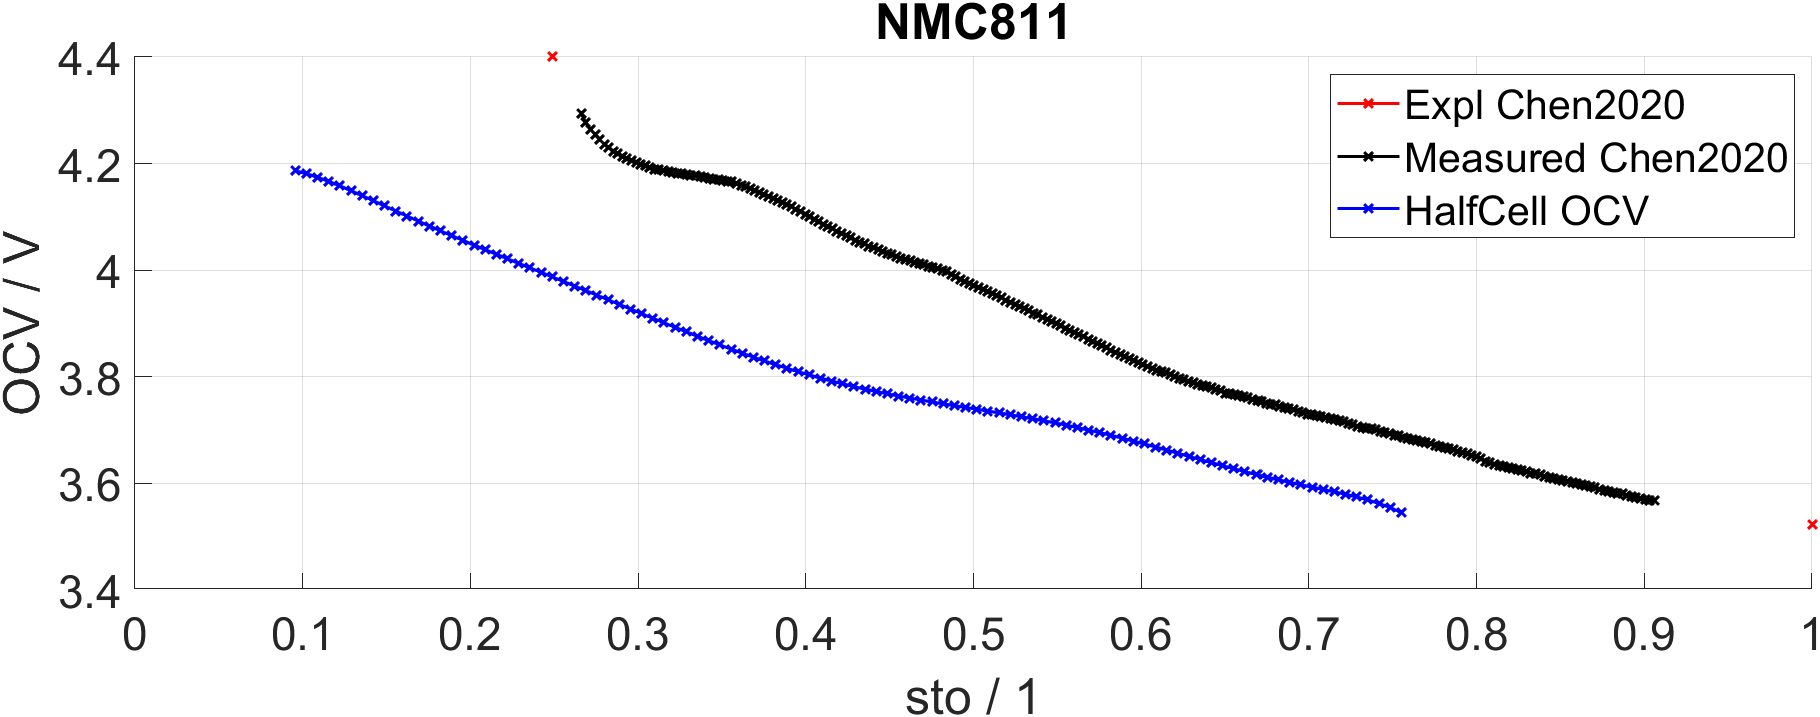

Man erkennt deutliche Unterschiede in den Features der Kurven und vor allem einen deutlich anderen Stöchiometriebereich. 

Ein weiteres wichtiges Detail ist sind die Punkte bei x=0,1 als die physikalisch maximal und minimal erreichbaren Punkte, die in das Fitting einbezogen werden sollten, um Abdriften der Kurve außerhalb zwischen den Grenzen und den Messwerten zu begrenzen. Sonst sind beispielsweise negative Spannungen bei der negativen Elektrode möglich.

Die Parametersets lassen sich unter "pybamm\input\parameters\lithium_ion\data\nmc_LGM50_ocp_Chen2020.csv" bzw. "pybamm\input\parameters\lithium_ion\data\graphite_LGM50_ocp_Chen2020.csv" finden.

### 2.1.2 Wie wird der anfängliche Ladezustand bestimmt?
Die Abweichung der stöchiometrischen Bereiche der jeweilgen OCV Kurven deuten auf die Notwendigkeit der weiteren Anpassung mit dem Material und der Stöchiometrie zusammenhängenden Größen hin.

So muss die die maximale Konzentration für das Aktivmaterial bestimmt werden. Diese berechnet sich nach Chen.2020 für die Elektroden (k=p,n) zu:

$$ c_{k,s}^{max} = \frac{M_{k,coat}z_k}{m_{k,a}L_k\varepsilon_{k,act}} $$
<span style="color:grey">Quelle: *Chen.2020* - Gl. (5)</span>.

Der Ladezustand kann als Argument *inital_soc* in der Klasse `pybamm.simulation` übergeben werden. Darauf folgt für Lithium-Ionen Batterien die Berechnung der Lithiumionenkonzentration $c_{k,s}$ in den Partikeln des Aktivmaterials gegenüber der maximalen Konzentration im Aktivmaterial der Kathode und Anode (s. Gl. (1)). Dies wird in PyBaMM auch als `initial_stoichiometries` beschrieben. Ohne Definition des *inital_soc*, werden die anfänglichen Konzentrationen (`initial concentration`) aus dem Parameterset genutzt nach $x=\frac{c_{k,s}}{c_{k,s}^{max}}$ bestimmt. 

Derzeit (24.01.2023) funktioniert der Prozess zum Setzen des anfänglichen Ladezustands nicht. Der Fehler deutet daraufhin, dass das die Bestimmung der maximalen und minimalen Stöchiometrien für die Zelle nicht funktionieren.

*  pybamm.Simulation(kwargs).solve(initial_soc=soc_ini) - soc_ini = [0,1]
    * pybamm.simulation.set_initial_soc
        * pybamm.parameter_values.set_initial_stoichiometries
            * pybamm.lithium_ion.get_initial_stoichiometries -> esoh_solver.get_initial_stoichiometries
                * esoh_solver.get_min_max_stoichiometries
                    * <span style="color:red">**Was ist Q???**</span>.

Der Prozess der Bestimmung der maximalen und minimalen Grenzen beruht auf der..


---
<sup>1</sup> Chen, Chang-Hui; Brosa Planella, Ferran; O’Regan, Kieran; Gastol, Dominika; Widanage, W. Dhammika; Kendrick, Emma (2020): Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. In: J. Electrochem. Soc. 167 (8), S. 80534. DOI: 10.1149/1945-7111/ab9050.


### 2.1.2 Wie kann die von der Stöchiometrie abhängige OCV Kurve bestimmt werden?
Es wird die maximale und minimale Stöchiometrie für Aktivmaterialien aus den Halbzellversuchen bestimmt. 
Innerhalb der Vollzelle werden aufgrund des Stabilitätsfensters des Elektrolyten nur ein gewisser Bereich der möglichen Interkalationsbereich der Aktivmaterialien genutzt. Diese werden über Colomb Counting von dem komplett beladenen oder entladenen Aktivmaterial in einer Halbzelle gegen Lithium bestimmt. <span style="color:grey">Korrektur  durch Valerie</span>.
Die tatsächlich genutzen Bereich in der Vollzelle können folgend druch Fitting der der Halbzellkurven aus dem 3 Elektroden Setup der Vollzelle gegen die Halbzelle verglichen werden, um so den effektiv genutzten Bereich zu bestimmen. 
Nach Bestimmung der effektiven Interakalationbereiche, die sich automatisch durch die maximale Konzentration und der in der Zelle befindlichen Lithium Ionen bestimmt werden, kann bei Nutzung eines einzelnen GITT Messpunkt über der Stöchiometrie die anfänglichen Lithium-Konzentration in der Zelle bestimmt werden. 

## 2.2 Anpassung Parameterwerte (Konstanten)

### 2.2.1 Anpassung materialspezifische Daten
Bei dem Vergleich mit den Daten des Ursprungsdatensets kam bei dem Vergleich der OCV Kurven für das NMC aus dem Datenset des Chen2020 Papers und unserem NMC von CC eine Differenz des Lithiierungsbereichs auf. 

"Gleichung für x"

Dei maximale Konzentration von Lithium-Ionen im Aktivmaterial ergibt nach Chen.2020 sich zu:

"c_max Gleichung"

Dies ergibt für die Spezifikationen unsern Materials (s. Parametertabelle):

In [10]:
# parameter_values["Maximum concentration in positive electrode [mol.m-3]"] = 46846.345 #own parameterset
parameter_values.update({"Maximum concentration in positive electrode [mol.m-3]": 46846.345,
                         "Maximum concentration in negative electrode [mol.m-3]": 23406.320}, check_already_exists=False)
# parameter_values.update({"Maximum concentration in negative electrode [mol.m-3]": 23406.320}, check_already_exists=False)
# parameter_values["Maximum concentration in negative electrode [mol.m-3]"] = 23406.320 #own parameterset
# parameter_values["Negative electrode diffusivity [m2.s-1]"] = 1e-15
# parameter_values["Positive electrode diffusivity [m2.s-1]"] = 1.4e-15

### 2.2.2 Anpassung geometrische Daten
Umrechnen von Durchmesser der Laborzellenelektroden von 18 mm in eine quadratische Oberfläche, da die Elektrodenfläche in PyBaMM als viereckige Fläche berechnet wird.

In [11]:
Diameter=18e-3
cell_geoquad= (Diameter**2/4*np.pi)**(1/2)
print(cell_geoquad)
# print(parameter_values["Electrode width [m]"])

0.015952084658149644


Zur Modellierung der Laborzelle müssen weitere Parameter angepasst werden.

In [12]:
## Geometrische Parameter der Aktivmterialien zur Berechnung der Kapazität
parameter_values.update({"Positive electrode porosity": 0.38,
                         "Negative electrode porosity": 0.25,
                         "Positive electrode thickness [m]": 4.24e-5,
                         "Negative electrode thickness [m]": 5.0e-5,
                         "Electrode width [m]": cell_geoquad,
                         "Electrode height [m]": cell_geoquad,
                         "Positive electrode active material volume fraction": 1-parameter_values["Positive electrode porosity"],
                         "Negative electrode active material volume fraction": 1-parameter_values["Negative electrode porosity"],
                         "Separator thickness [m]": 2.6e-4,
                         "Separator porosity": 0.91
                         }, check_already_exists=False)


# parameter_values["Positive electrode thickness [m]"] = 4.24e-5 #measured thickness - collector foil thickness of data sheet (20 µm)
# parameter_values["Negative electrode thickness [m]"] = 5.0e-5  #measured thickness - collector foil thickness of data sheet (14 µm)
# parameter_values["Electrode width [m]"] = cell_geoquad
# parameter_values["Electrode height [m]"] = cell_geoquad
# parameter_values["Positive electrode active material volume fraction"] = 1-parameter_values["Positive electrode porosity"] # fraction of filled proes to active material - not binder or composition of active material
# parameter_values["Negative electrode active material volume fraction"] = 1-parameter_values["Negative electrode porosity"] # fraction of filled proes to active material - not binder or composition of active material

## Geometrische Separatorwerte
# parameter_values["Separator thickness [m]"] = 2.6e-4
# parameter_values["Separator porosity"] = 0.91
# parameter_values["Typical electrolyte concentration [mol.m-3]"] = 

## Mechanische Expansion
# pybamm.parameters_cli.add_parameter()



### 2.2.3 Anpassung elektrische Daten
Festlegen der elektrischen Grenzen. Direkt aus experimenteller Bestimmung.
Für 100 % SOC:

$$ c_{p,s}^{ini} = c_{p,s}^{max} * x_{p,0}$$

$$ c_{n,s}^{ini} = c_{n,s}^{max} * x_{n,100}$$



In [25]:
## Elektrische Parameter
parameter_values.update({"Upper voltage cut-off [V]": 4.2,
                         "Lower voltage cut-off [V]": 3.0,
                         "Nominal cell capacity [A.h]": 5.1e-3}, check_already_exists=False
                         
                         
                        )
# parameter_values["Upper voltage cut-off [V]"] = 4.2
# parameter_values["Lower voltage cut-off [V]"] = 3.0
# parameter_values["Nominal cell capacity [A.h]"] = 5.1e-3 # only for conversion between current and C-rate

## Stöchiometerische Grenzen # for negative electrode already done in Chen2020
parameter_values.update({"Initial concentration in positive electrode [mol.m-3]": 0.15*parameter_values["Maximum concentration in positive electrode [mol.m-3]"],
                         "Initial concentration in negative electrode [mol.m-3]": 0.95*parameter_values["Maximum concentration in negative electrode [mol.m-3]"]}, check_already_exists=False)

# pybamm.lithium_ion.electrode_soh.get_min_max_stoichiometries(parameter_values)
# parameter_values.values()
parameter_values.search("Positive electrode diffusivity [m2.s-1]")

Positive electrode diffusivity [m2.s-1]	4e-15


### Test for contained Lithium ions
Hier wird die Menge an Lithium-Ionen im System und in den einzelnen Elektroden berechnet. Für den gegebenen Parametersatz werden die maximale und minimale Stöchiometrie in den Aktivmaterialien berechnet.

Besonderes zu beachten. Die Bestimmung der Diffusionskoeffizienten erfolgt in einem bestimmten Stöchiometriebereich in Abhängigkeit des durchgeführten Tests. Der Stöchiometriebereich sollte(muss?) größer sein als der in dem Betrieb der Zielzelle gebraucht wird, da es sonst zur Extrapolation kommt, was bei durch den Polynomfit zu einer Instabilitäten bei der Lösung führt.

In [26]:
# pybamm.lithium_ion.electrode_soh.get_min_max_stoichiometries(parameter_values = pybamm.ParameterValues("Chen2020"))
# pybamm.lithium_ion.electrode_soh.get_min_max_stoichiometries(parameter_values = pybamm.ParameterValues("Chen2020_AH_VM_modified"))
param =pybamm.LithiumIonParameters()
# parameter_values.search("vol") # Suche
Faraday = parameter_values.evaluate(param.F)
n_Li = parameter_values.evaluate(param.n_Li_e_init)
# eps_ini=parameter_values.evaluate(param.epsilon_init) # funktioniert nicht für function parameter..wenn dann average ziehen

Lx = parameter_values.evaluate(param.L_x)

Acc = parameter_values.evaluate(param.A_cc)
eps_n=parameter_values["Negative electrode active material volume fraction"]
c_max_n=parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
Q_AM_n=Acc*parameter_values.evaluate(param.n.L)*eps_n*Faraday/3600*c_max_n

n_p=parameter_values.evaluate(param.p.n_Li_init)
n_n=parameter_values.evaluate(param.n.n_Li_init)
Q_n = parameter_values.evaluate(param.n.Q_Li_init)
Q_p = parameter_values.evaluate(param.p.Q_Li_init)
Q_Li = parameter_values.evaluate(param.Q_Li_particles_init)
Q_p_init= parameter_values.evaluate(param.p.Q_init)
Q_n_init= parameter_values.evaluate(param.n.Q_init)
print("Initial lihthium ions in positive and overall: \n",Q_p,"\n",Q_n,"\n",Q_Li,"\n")
test=Q_n+Q_p
# print((Q_Li - 1e-6 * Q_p) / Q_n)
# print((Q_Li - 1 * Q_n) / Q_p)
# print((Q_Li - 1 * Q_p) / Q_n)
# print((Q_Li - 1e-6 * Q_n) / Q_p)
check=pybamm.lithium_ion.get_min_max_stoichiometries(parameter_values)
print("min sto neg elec, max sto neg elect, min sto pos elec, max sto pos elec \n",check)
# parameter_values.evaluate(param.n.Q_init)

Initial lihthium ions in positive and overall: 
 0.001351288747494238 
 0.005686979963382843 
 0.0070382687108770815 

0.033648149709131187 0.9999889477357748
min sto neg elec, max sto neg elect, min sto pos elec, max sto pos elec 
 [0.033648149709131187, 0.9999889477357748, 0.1167818695272498, 0.7589245063289036]


## 3 Experimentdefinition - C rate test
Definition von Experiment. Bringen auf richten Ausgangszustand zuvor

In [28]:
C_Rate_test = pybamm.Experiment(
    [
        ("Discharge at 1 C until 3.0 V",
        "Rest for 5 minutes",
        "Charge at 1 C until 4.2 V",
        "Hold at 4.2 V until C/10",
        "Rest for 5 minutes"),
    ] * 1
) #for 1 hours or

C10_comparison_PAT_LPC = pybamm.Experiment(
    [
        (
        "Charge at 0.1 C until 4.2 V",
        )
    ] * 1
) 

C1_Pulse_Test = pybamm.Experiment(
    [
        (
        "Rest for 5 minutes",
        "Charge at 0.5 C for 4 minutes",
        "Rest for 30 minutes",
        "Discharge at 0.5 C for 4 minutes",
        "Rest for 5 minutes",
        )
    ] * 1
) 

Capped_Rate_test = pybamm.Experiment(
    [
        ("Discharge at 1 C until 3.2 V",
        "Rest for 5 minutes",
        "Charge at 1 C until 4.2 V",
        "Rest for 5 minutes"),
    ] * 1
) #for 1 hours or


#for 1 hours or
# "Charge at 1 C until 4.2 V",
#         "Hold at 4.2 V until C/10",
#         "Rest for 5 minutes",

### 3.1 Simulation des Modells

In [29]:
#load solvers
fast_solver = pybamm.CasadiSolver(atol=1e-3, rtol=1e-3, mode="fast")
sols=[]
for model in models:
    sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=C_Rate_test) #, experiment=C_Rate_test
    # np.linspace(0, 2520, 100)
    sol=sim.solve() #initial_soc=0.5
    sols.append(sol)
# t_eval = np.arange(0, 12001, 1)
# sol = sim.solve() #[0, 7200], t_eval=t_eval, initial_soc=1


At t = 243.644, repeated recoverable residual errors.


In [30]:
dfn.variables.search("Discharge")
output_variables = ["Positive electrode potential [V]","Positive electrode open-circuit potential [V]", "Negative electrode potential [V]","Negative electrode open-circuit potential [V]" , "Terminal voltage [V]","Positive electrode stoichiometry","Negative electrode stoichiometry","Battery open-circuit voltage [V]","Volume-averaged cell temperature [K]","Electrolyte concentration [mol.m-3]","Negative electrode surface potential difference [V]","Negative electrode reaction overpotential [V]","Exchange current density [A.m-2]","Discharge capacity [A.h]"] #,"Cell thickness change [m]"
pybamm.dynamic_plot(sols, output_variables=output_variables, time_unit="seconds")

Discharge capacity [A.h]
Discharge energy [W.h]


interactive(children=(FloatSlider(value=0.0, description='t', max=9337.524282683333, step=93.37524282683333), …

In [ ]:
SoC_init=0.5
a = sim.solution["Discharge capacity [A.h]"].entries
b = parameter_values["Nominal cell capacity [A.h]"]
SoC = SoC_init - a/b
# print(SoC)
# sim.plot(SoC.reshape(-1))

### Suche nach Variablen in verschiedenen Sets
Anteilige Auflistung der Spannungsanteile zur Spannungskurve

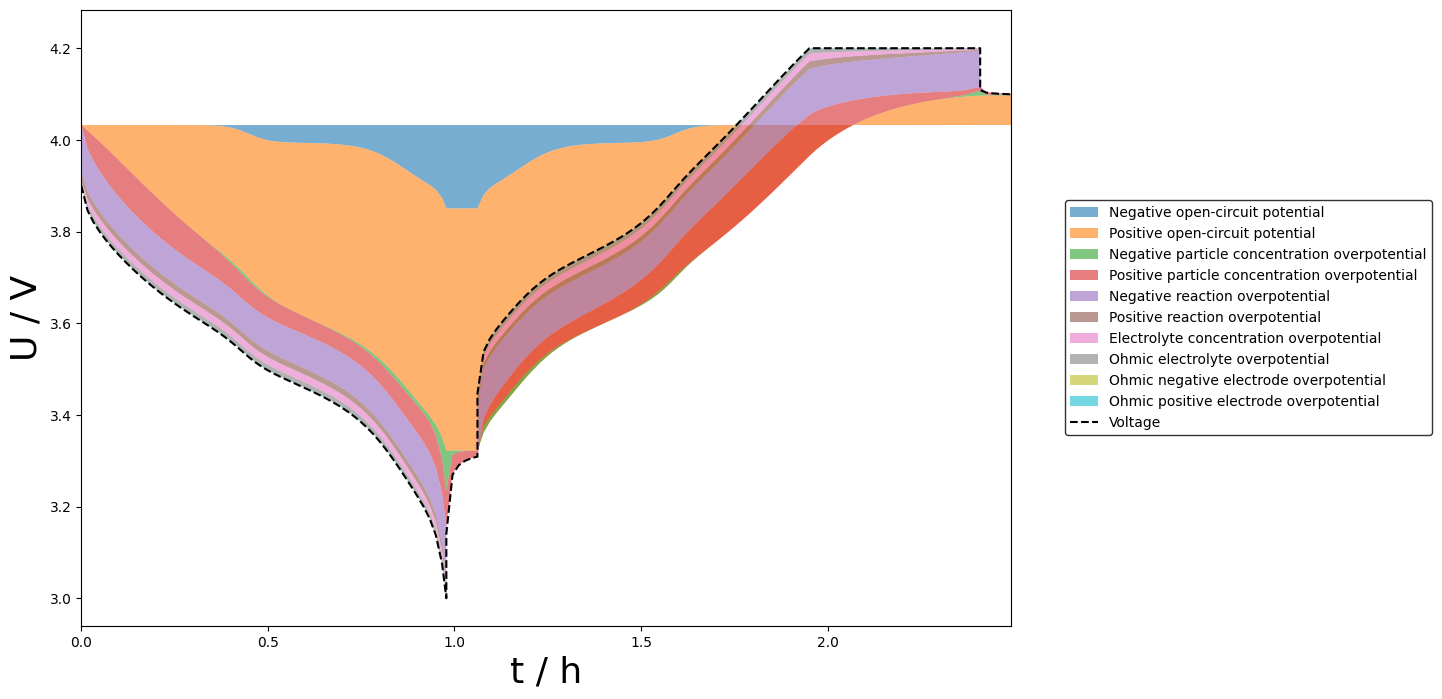

In [ ]:
# f = figsize=(20,8)

# test=os.environ.get('PYTHONPATH', '').split(os.pathsep)
# print(test)

fig,ax1 = plt.subplots()
fig.set_size_inches(12,8)
pybamm.plot_voltage_components(sols[0],ax=ax1,split_by_electrode=True)
plt.xlabel("t / h", fontsize=26)
plt.ylabel("U / V", fontsize=26)
# xpoints = np.array([1, 8])
# ypoints = np.array([3, 10])
# plt.plot(xpoints, ypoints)
plt.rcParams.update({'font.size': 18})
date=datetime.now()
today=date.strftime("%Y%m%d")

plt.savefig(pathlib.PureWindowsPath('C:/Users/ahe16/Documents/GitHub/PyBaMM_Fork/scripts/testing/Laborzelle/C_rate_experiment/',today+"_volt_comp"+".jpg"),dpi=400,bbox_inches='tight',pad_inches=0)
# plt.savefig(r"C:\Users\ahe16\Documents\GitHub\PyBaMM_Fork\scripts\testing\Laborzelle\C_rate_experiment\test.jpg",dpi=400,bbox_inches='tight',pad_inches=0)

## Betrachtung der Reaktionsüberspannungen
Es zeigt sich bei der Übersicht, dass die Reaktionsüberspannungen gerade bei der negativen Elektrode sehr hoch ausfallen. Diese hängen von der Kinetik an den Elektrodenoberflächen ab. Diese sind in dem `pybamm.BaseBatteryModel` regulär auf eine symetrisch definierte Butler-Volmer-Gleichung ("..\pybamm\models\submodels\interface\kinetics").
The overpotential `eta_r`ist mostly dependent on the surface potential of each electrode and the OCP distribtion over the surface area.
...continue at some point


In [ ]:
dfn.submodels["negative primary interface"]

### Studie zu den Anfangswertbedinungen
Bei der Definition der Experimente ist es wichtig auf den gleichen Anfangszustand zu kommen. Dazu gibt es bei der Simulation ([Dokumentation-Simulation](https://pybamm.readthedocs.io/en/latest/_modules/pybamm/simulation.html#Simulation.solve)) der Lösung, die Möglichkeit die den anfänglichen Ladezustand über `initial_soc` (0 bis 1) den anfänglichen Ladezustand zu bestimmen. 



Der anfängliche Ladezustand wird dann anhand von Lade- und Entladeschlussspannung, sowie den OCV Kurven zu der negativen und positiven Elektrode bestimmt. Die OCV Kurven werden wie von der Modellparameterliste getrennt für Kathode und Anode festgelegt. Wie dort auch festgelegt ist das Potential abhängig von der Stöchiometrie in dem Aktivmaterial, also wie oben das Verhältnis der Lithiumionenkonzentration gegenüber der maximalen Konzentration in dem Material. Je nach Festlegung der Ladeschlussspannungen wird nur ein Teil der theoretischen Kapazität der Materialien genutzt, was sich in der Praxis meist durch eine dadurch höhrere Lebensdauer lohnt.

##### To do 
- Tiefer einsteigen
- OCV Kurven für Kathode und Anode tauschen
- Gibt es noch andere Abhängigkeiten bei der Begrenzung der OCV Fenster als Ladeschlussspannungen?


#### Definition des vorherigen Zellhistorie
Bei der Simulation von Vorgängen sollte auf die Historie der Zelle geachtet werden, so kann der Anfangszustand driekt vor dem Test der eigentlich simuliert werden soll, auch simuliert werden.


In [ ]:
param = pybamm.LithiumIonParameters()
# V_min = parameter_values.evaluate(param.voltage_low_cut_dimensional)
# V_max = parameter_values.evaluate(param.voltage_high_cut_dimensional)
C_n = parameter_values.evaluate(param.n.cap_init)
C_p = parameter_values.evaluate(param.p.cap_init)
n_Li = parameter_values.evaluate(param.n_Li_particles_init)

x, y = pybamm.lithium_ion.get_initial_stoichiometries(1, parameter_values)
# pybamm.lithium_ion.ElectrodeSOHSolver
print(x,y)
# pybamm.plot(sol.t,sol.y)


0.03402026139558907 0.9999901381741085
0.03402026139558907 0.9999901381741085 0.7254517597723443 0.08355560366239113
0.9999901381741085 0.08355560366239112


In [ ]:
path_csv=pathlib.PureWindowsPath('C:/Users/ahe16/Documents/GitHub/PyBaMM_Fork/scripts/testing/Laborzelle/C_rate_experiment/',today+"_DiffKoe_test_BA_RB_Li_ref"+".csv")
path_mat=pathlib.PureWindowsPath('C:/Users/ahe16/Documents/GitHub/PyBaMM_Fork/scripts/testing/Laborzelle/C_rate_experiment/',today+"_DiffKoe_test_BA_RB_constant4-e15"+".mat")

### Save data to csv and matlab for further analysis

In [ ]:
sol.save_data(path_csv, ["Time [s]", "Current [A]", "Terminal voltage [V]"], to_format="csv")
sol.save_data(path_mat, ["Time [s]", "Current [A]", "Terminal voltage [V]"], to_format="matlab",
              short_names={"Time [s]": "t", "Current [A]": "I", "Terminal voltage [V]": "V"})


how to change the time of export?

In [ ]:
# pybamm.print_citations()

#print(sol["Time [s]"])